<i>Copyright (c) Recommenders contributors.</i>

<i>Licensed under the MIT License.</i>

# Click History

## Global settings and imports

In [2]:
import tensorflow.keras

2023-12-04 15:11:30.171157: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-04 15:11:30.313931: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-04 15:11:31.258055: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 15:11:31.260037: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 15:11:31.428734: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [3]:
import sys
import os
import numpy as np
import zipfile
from tqdm import tqdm
import scrapbook as sb
from tempfile import TemporaryDirectory
import tensorflow as tf
# tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.models.deeprec.deeprec_utils import download_deeprec_resources 
from recommenders.models.newsrec.newsrec_utils import prepare_hparams
from recommenders.models.newsrec.models.npa import NPAModel
from recommenders.models.newsrec.io.mind_iterator import MINDIterator
from recommenders.models.newsrec.newsrec_utils import get_mind_data_set

print("System version: {}".format(sys.version))
print("Tensorflow version: {}".format(tf.__version__))

System version: 3.9.12 (main, Jun  1 2022, 11:38:51) 
[GCC 7.5.0]
Tensorflow version: 2.15.0


## Prepare Parameters

In [4]:
epochs = 5
seed = 42
batch_size = 32

# Options: demo, small, large
MIND_type = 'demo'

## Download and load data

In [5]:
tmpdir = TemporaryDirectory()
data_path = tmpdir.name

train_news_file = os.path.join(data_path, 'train', r'news.tsv')
train_behaviors_file = os.path.join(data_path, 'train', r'behaviors.tsv')
valid_news_file = os.path.join(data_path, 'valid', r'news.tsv')
valid_behaviors_file = os.path.join(data_path, 'valid', r'behaviors.tsv')
wordEmb_file = os.path.join(data_path, "utils", "embedding.npy")
userDict_file = os.path.join(data_path, "utils", "uid2index.pkl")
wordDict_file = os.path.join(data_path, "utils", "word_dict.pkl")
yaml_file = os.path.join(data_path, "utils", r'npa.yaml')

mind_url, mind_train_dataset, mind_dev_dataset, mind_utils = get_mind_data_set(MIND_type)

if not os.path.exists(train_news_file):
    download_deeprec_resources(mind_url, os.path.join(data_path, 'train'), mind_train_dataset)
    
if not os.path.exists(valid_news_file):
    download_deeprec_resources(mind_url, \
                               os.path.join(data_path, 'valid'), mind_dev_dataset)
if not os.path.exists(yaml_file):
    download_deeprec_resources(r'https://recodatasets.z20.web.core.windows.net/newsrec/', \
                               os.path.join(data_path, 'utils'), mind_utils)

100%|██████████| 17.0k/17.0k [00:00<00:00, 41.6kKB/s]
100%|██████████| 9.84k/9.84k [00:00<00:00, 29.6kKB/s]
100%|██████████| 95.0k/95.0k [00:01<00:00, 69.5kKB/s]


   impression_id user_id         impression_time  \
0              1  U82271   11/11/2019 3:28:58 PM   
1              2  U84185  11/12/2019 10:36:47 AM   
2              3  U11552   11/11/2019 1:03:52 PM   
3              4  U68381   11/11/2019 6:44:05 AM   
4              5  U52303   11/12/2019 3:11:52 AM   

                                  user_click_history  \
0             N3130 N11621 N12917 N4574 N12140 N9748   
1  N27209 N11723 N4617 N12320 N11333 N24461 N2211...   
2                                              N2139   
3  N27420 N11621 N25416 N25457 N5124 N11751 N1175...   
4                                       N1332 N12667   

                                     impression_news  
0  N13390-0 N7180-0 N20785-0 N6937-0 N15776-0 N25...  
1  N13089-0 N18101-0 N1248-0 N26273-0 N12770-1 N1...  
2                         N18390-0 N10537-0 N23967-1  
3  N15660-0 N18609-0 N2831-0 N5677-0 N19010-0 N15...  
4                                   N15645-0 N7911-1  


NameError: name 'df_news' is not defined

# Examine News Data

## Examine categories

In [29]:
import pandas as pd
# This file contains news information including newsid, category, subcategory, 
# news title, news abstarct, news url and entities in news title, entities in news abstract.

columns = ['newsid', 'category', 'subcategory', 'news title', 'news abstract', 'news url', 'entities in news title', 'entities in news abstract']

# Load the TSV file with specified column names
df_news = pd.read_csv(train_news_file, delimiter='\t', names=columns)


,newsid,category,subcategory,news title,news abstract,news url,entities in news title,entities in news abstract
0,N3112,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://www.msn.com/en-us/lifestyle/lifestyler...,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N10399,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://www.msn.com/en-us/news/world/the-cost-...,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
2,N12103,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://www.msn.com/en-us/health/voices/i-was-...,[],"[{""Label"": ""National Basketball Association"", ..."
3,N20460,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://www.msn.com/en-us/health/medical/how-t...,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."
4,N5409,weather,weathertopstories,It's been Orlando's hottest October ever so fa...,There won't be a chill down to your bones this...,https://www.msn.com/en-us/weather/weathertopst...,"[{""Label"": ""Orlando, Florida"", ""Type"": ""G"", ""W...","[{""Label"": ""Orlando, Florida"", ""Type"": ""G"", ""W..."


In [30]:
import pandas as pd

# Assuming you've already loaded the news data as df_news

# Specify columns for the behaviors data
behavior_columns = ['impression_id', 'user_id', 'impression_time', 'user_click_history', 'impression_news']


# Assuming you've already loaded the news data as df_news

# Load the behaviors data
# Replace 'train_behaviors_file' with the path to your behaviors data file
df_behaviors = pd.read_csv(train_behaviors_file, delimiter='\t', names=behavior_columns)

# Process the user click history
# Split the click history string into a list of news IDs, handling non-string values
df_behaviors['user_click_history'] = df_behaviors['user_click_history'].apply(lambda x: x.split() if isinstance(x, str) else [])

# Create functions to map news IDs to categories and subcategories
def map_news_to_category(news_ids, news_df):
    return [news_df.loc[news_id, 'category'] for news_id in news_ids if news_id in news_df.index]

def map_news_to_subcategory(news_ids, news_df):
    return [news_df.loc[news_id, 'subcategory'] for news_id in news_ids if news_id in news_df.index]

# Set newsid as the index in df_news for easier lookup
df_news.set_index('newsid', inplace=True)

# Map each user's click history to categories and subcategories
df_behaviors['categories'] = df_behaviors['user_click_history'].apply(lambda x: map_news_to_category(x, df_news))
df_behaviors['subcategories'] = df_behaviors['user_click_history'].apply(lambda x: map_news_to_subcategory(x, df_news))

# Example: View the categories and subcategories for the first few users
df_behaviors[['user_id', 'categories', 'subcategories']].head()



,user_id,categories,subcategories
0,U82271,"[lifestyle, sports, news, tv, sports, health]","[lifestylebuzz, football_nfl, newsus, tv-galle..."
1,U84185,"[foodanddrink, tv, news, finance, news, health...","[foodnews, tvnews, newscrime, finance-real-est..."
2,U11552,[sports],[football_nfl]
3,U68381,"[sports, sports, sports, tv, health, sports, s...","[football_nfl, football_nfl, football_nfl, tv-..."
4,U52303,"[entertainment, news]","[entertainment-celebrity, newsopinion]"


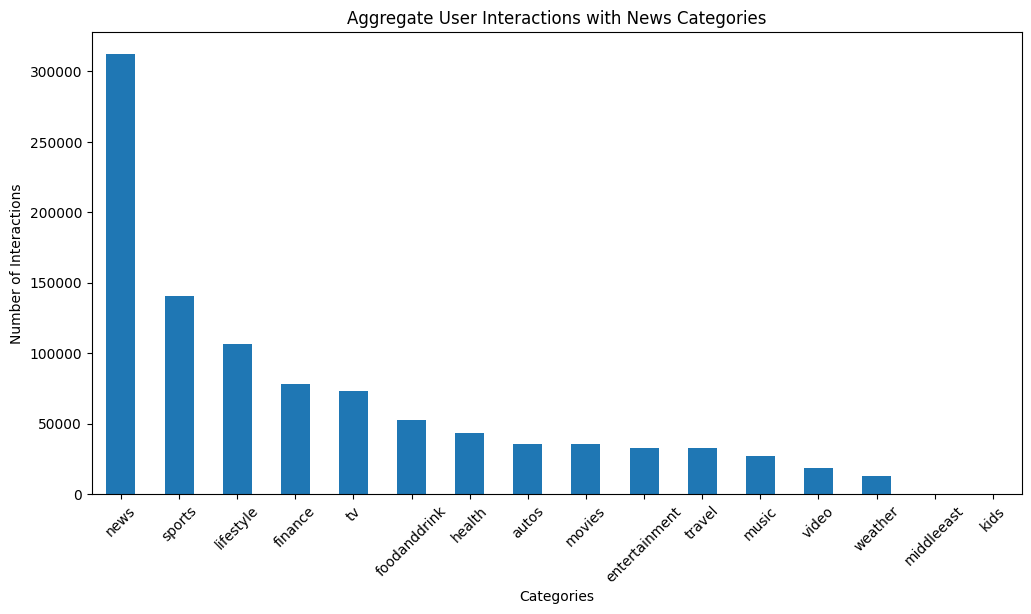

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_behaviors is already loaded and contains 'user_id' and 'categories' columns

# Explode the categories column into separate rows
df_exploded = df_behaviors.explode('categories')

# Aggregate data across users
category_counts = df_exploded['categories'].value_counts()

# Plotting the data with a bar graph
plt.figure(figsize=(12, 6))
category_counts.plot(kind='bar')
plt.title("Aggregate User Interactions with News Categories")
plt.xlabel("Categories")
plt.ylabel("Number of Interactions")
plt.xticks(rotation=45)  # Rotate category labels for better readability
plt.show()


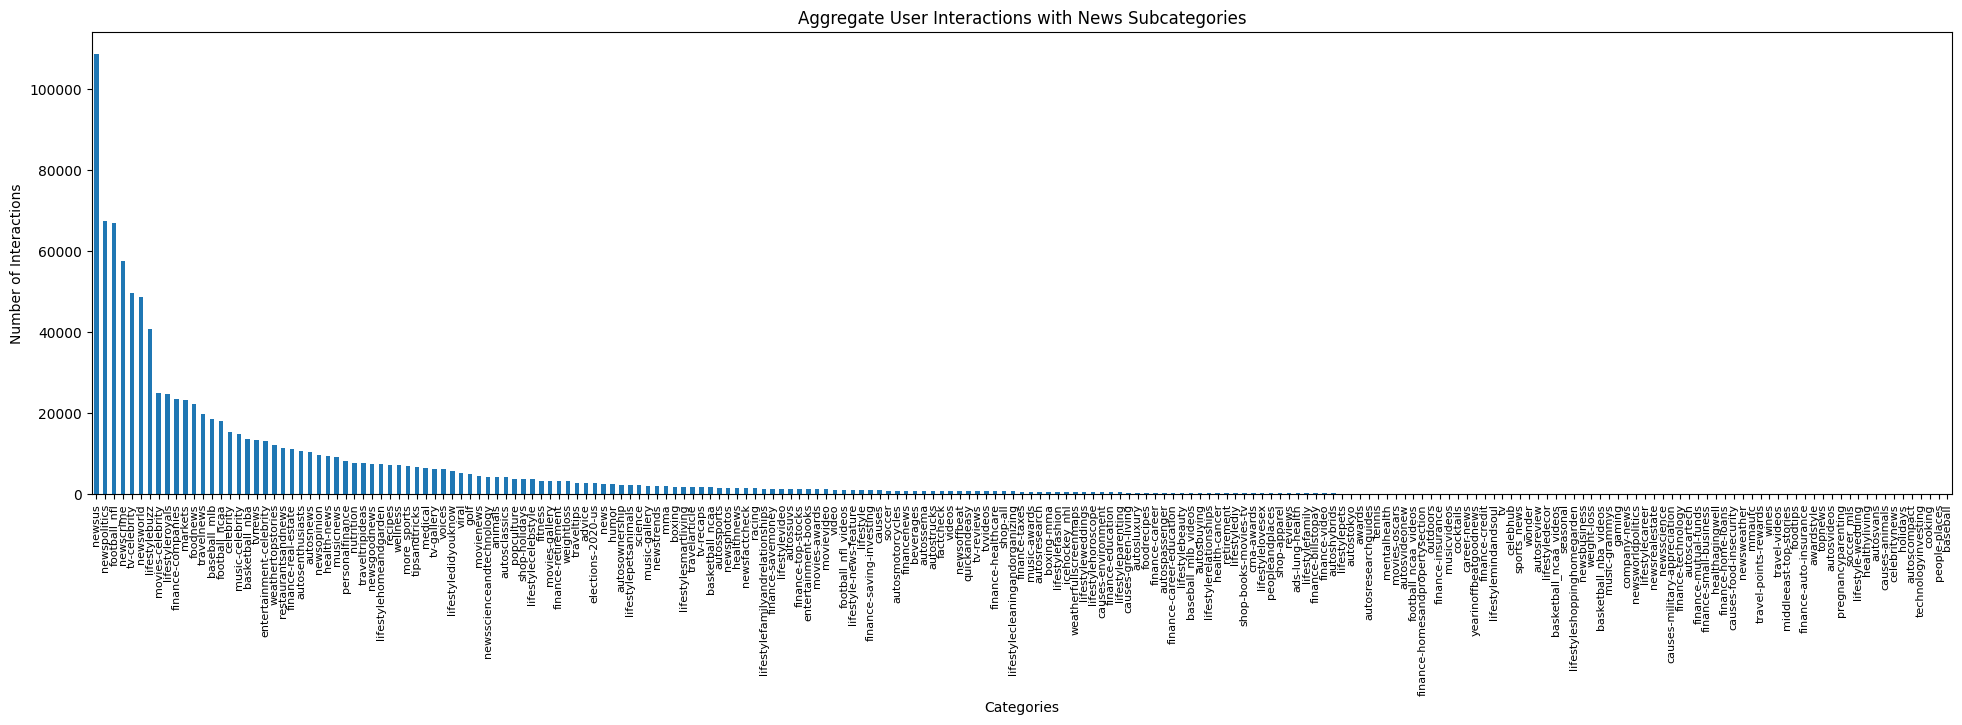

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_behaviors is already loaded and contains 'user_id' and 'categories' columns

# Explode the categories column into separate rows
df_exploded = df_behaviors.explode('subcategories')

# Aggregate data across users
category_counts = df_exploded['subcategories'].value_counts()

# Plotting the data with a bar graph
plt.figure(figsize=(24, 6))
category_counts.plot(kind='bar')
plt.title("Aggregate User Interactions with News Subcategories")
plt.xlabel("Categories")
plt.ylabel("Number of Interactions")
plt.xticks(rotation=90, size=8)  # Rotate category labels for better readability
plt.show()


In [49]:
import pandas as pd

# Assuming df_behaviors is already loaded and contains 'user_id' and 'categories' columns

# Explode the categories column into separate rows
df_exploded = df_behaviors.explode('categories')

# Count interactions per category for each user
user_category_counts = df_exploded.groupby(['user_id', 'categories']).size().reset_index(name='counts')

# Sort and then group by user_id, picking the top N categories for each user
N = 3  # You can change N to get more or fewer top categories
top_categories_by_user = user_category_counts.sort_values(['user_id', 'counts'], ascending=[True, False])
top_categories_by_user = top_categories_by_user.groupby('user_id').head(N)

# Display the result
top_categories_by_user


,user_id,categories,counts
3,U10008,news,11
6,U10008,tv,3
7,U10008,weather,3
12,U10044,news,21
10,U10044,lifestyle,9
...,...,...,...
33847,U9996,entertainment,3
33848,U9996,foodanddrink,3
33853,U9999,news,14
33855,U9999,video,2


/tmp/ipykernel_10539/456920293.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='categories', y='counts', data=sampled_data, palette="Set3")


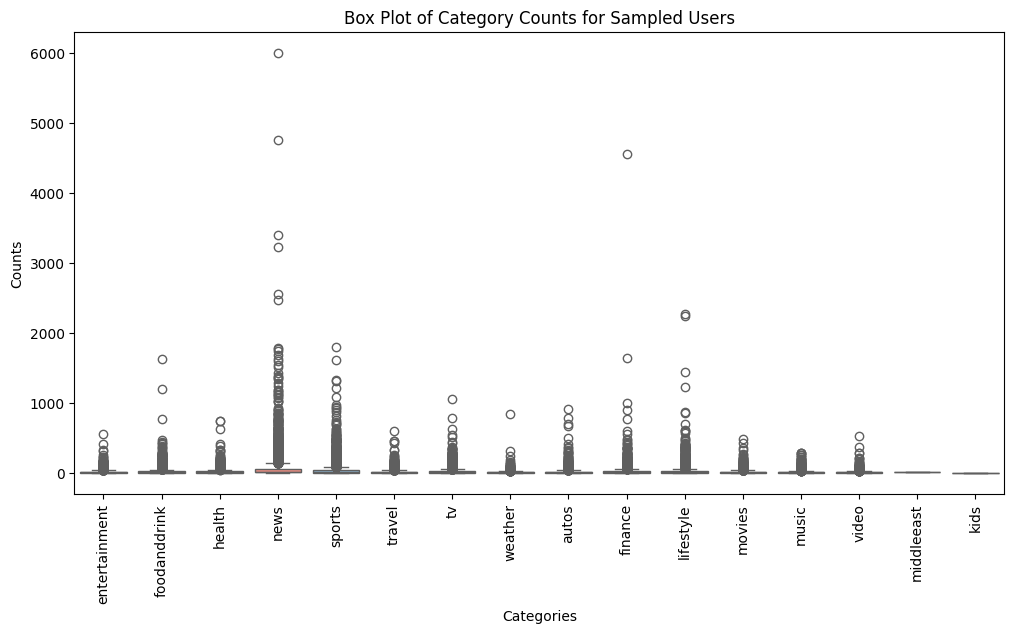

In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming user_category_counts is already created

# Sample a subset of users
sampled_users = user_category_counts['user_id'].drop_duplicates()  # Adjust n as needed
sampled_data = user_category_counts[user_category_counts['user_id'].isin(sampled_users)]

# Plotting the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='categories', y='counts', data=sampled_data, palette="Set3")

plt.xticks(rotation=90)
plt.title("Box Plot of Category Counts for Sampled Users")
plt.xlabel("Categories")
plt.ylabel("Counts")
plt.show()


In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_behaviors is already loaded and contains 'user_id' and 'subcategories' columns

# Explode the subcategories column into separate rows
df_exploded = df_behaviors.explode('subcategories')

# Count interactions per subcategory for each user
user_subcategory_counts = df_exploded.groupby(['user_id', 'subcategories']).size().reset_index(name='counts')

# Sample a subset of users
sampled_users = user_subcategory_counts['user_id'].drop_duplicates() # Adjust n as needed
sampled_data = user_subcategory_counts[user_subcategory_counts['user_id'].isin(sampled_users)]



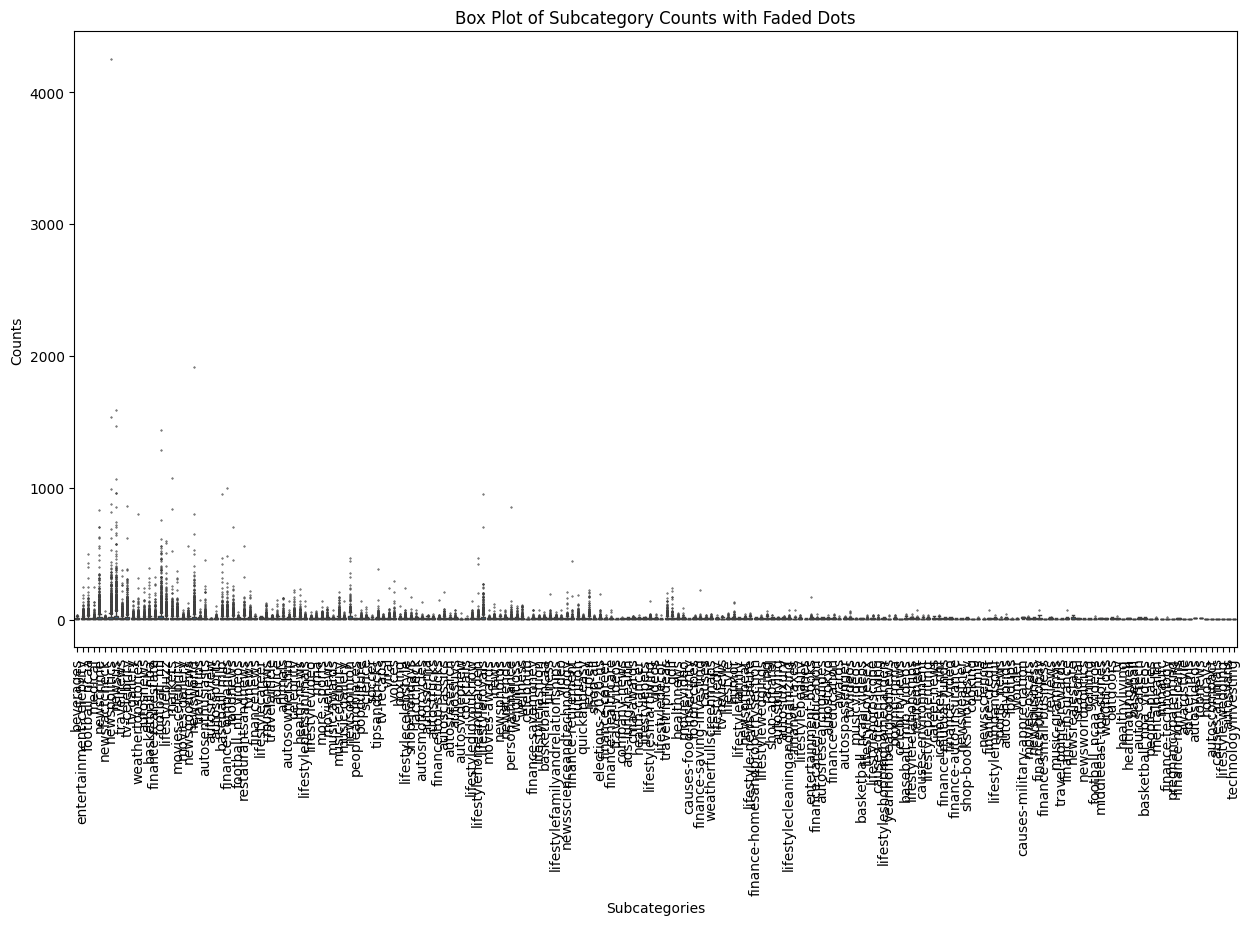

In [97]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming user_subcategory_counts is already created and contains 'user_id', 'subcategories', and 'counts'

# Plotting the box plot for subcategories with faded dots
plt.figure(figsize=(15, 8))  # Adjust the figure size as neede
sns.boxplot(x='subcategories', y='counts', data=user_subcategory_counts, flierprops=dict(marker='.', markersize=1))

# Display the pl
# sns.stripplot(x='subcategories', y='counts', data=user_subcategory_counts, color='grey', alpha=0.1, jitter=True, size=1)

plt.xticks(rotation=90)  # Rotate the labels for better readability
plt.title("Box Plot of Subcategory Counts with Faded Dots")
plt.xlabel("Subcategories")
plt.ylabel("Counts")

plt.show()


In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_behaviors is already loaded and contains 'user_id' and 'categories' columns

# Explode the categories column into separate rows
df_exploded = df_behaviors.explode('c')

# Count the number of times each user interacts with each category
category_counts = df_exploded.groupby(['user_id', 'categories']).size().reset_index(name='counts')

# Pivot the data for easier plotting
pivot_table = category_counts.pivot(index='user_id', columns='categories', values='counts').fillna(0)

# Plotting the data
# You can adjust this part based on your specific needs and preferences
plt.figure(figsize=(15, 10))
pivot_table.plot(kind='bar', stacked=True, figsize=(15, 10))
plt.title("User Interaction with News Categories")
plt.xlabel("User ID")
plt.ylabel("Number of Interactions")
plt.show()


SyntaxError: invalid syntax (784638007.py, line 7)

In [7]:
category_distribution = df['category'].value_counts()

category_distribution

news             8498
sports           6301
finance          1766
lifestyle        1511
foodanddrink     1474
travel           1229
health           1178
weather           968
video             933
autos             894
tv                670
music             496
movies            412
entertainment     399
kids                8
middleeast          2
northamerica        1
Name: category, dtype: int64

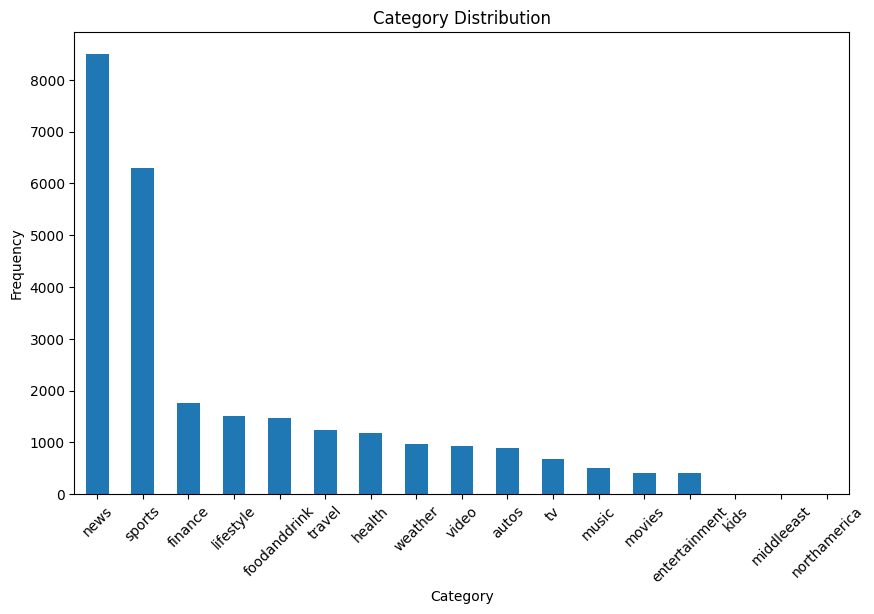

In [8]:
import matplotlib.pyplot as plt

# Count the number of occurrences of each category
category_distribution = df['category'].value_counts()

# Plotting the distribution as a bar graph
plt.figure(figsize=(10, 6))  # Adjust the size as needed
category_distribution.plot(kind='bar')
plt.title('Category Distribution')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotates the category names for better readability
plt.show()

## Visualize subcategories

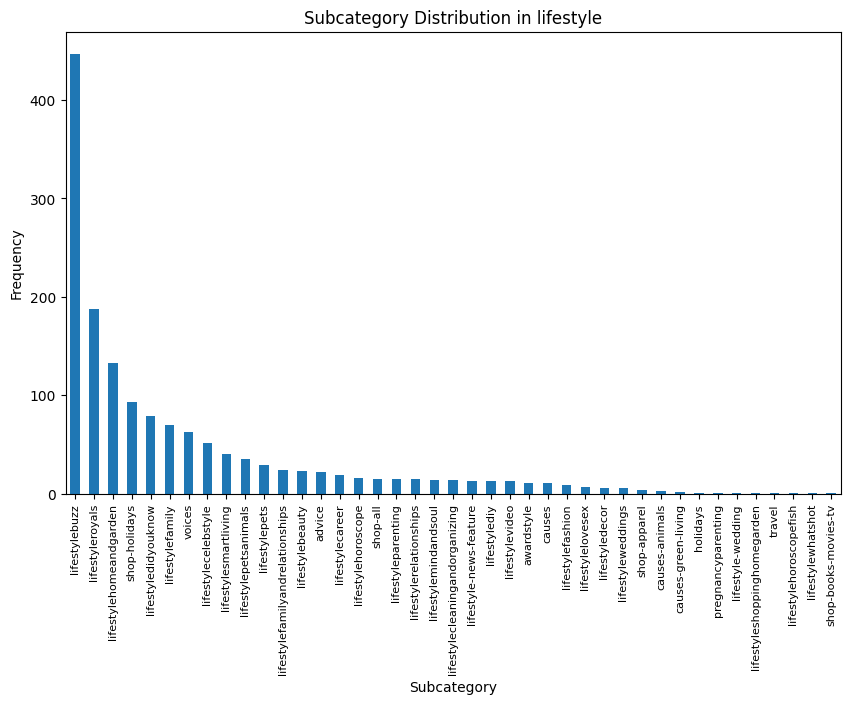

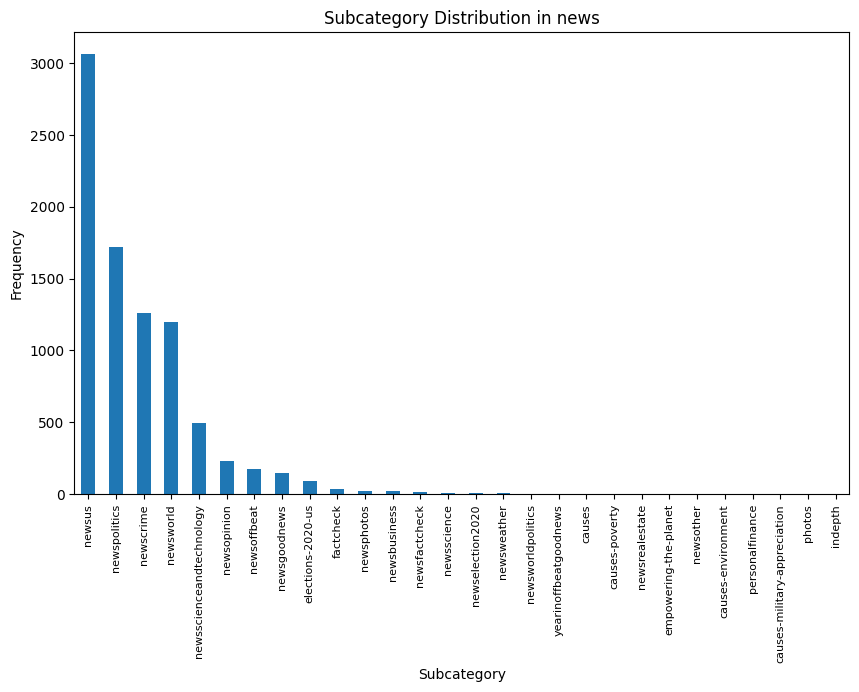

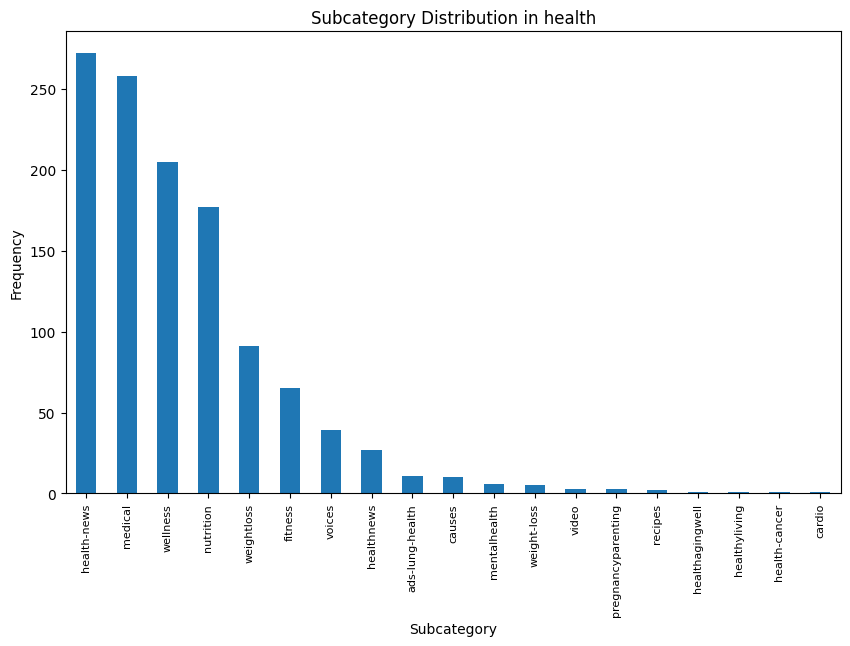

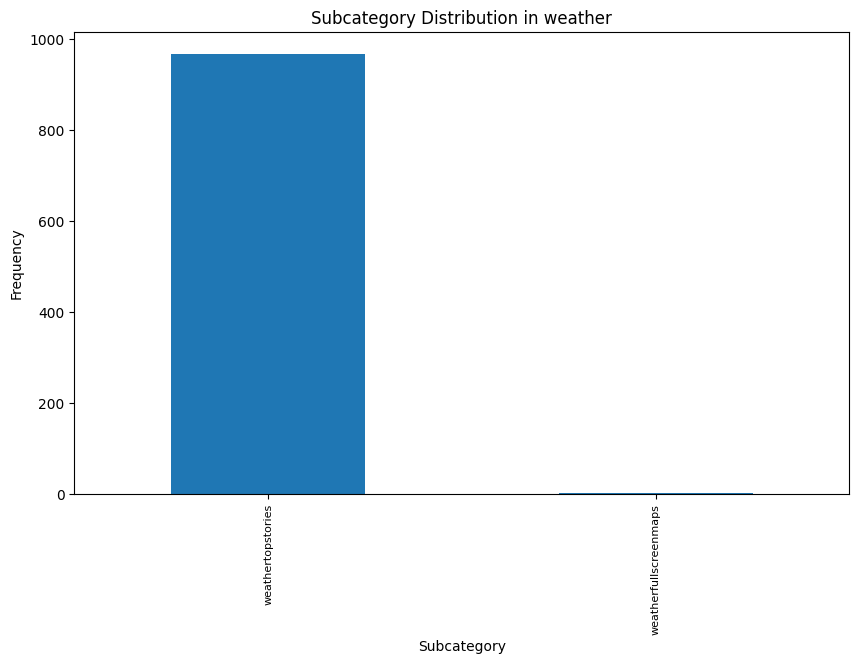

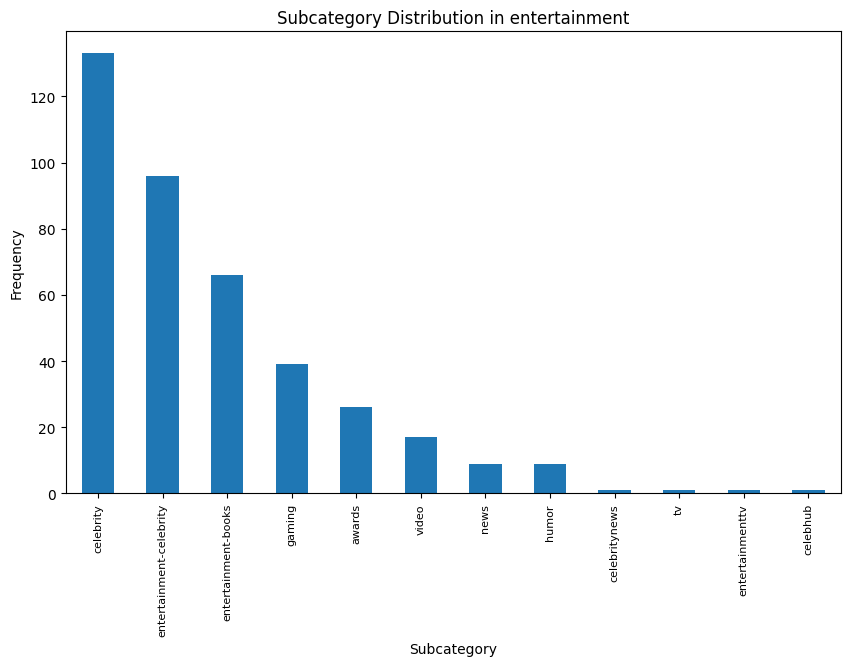

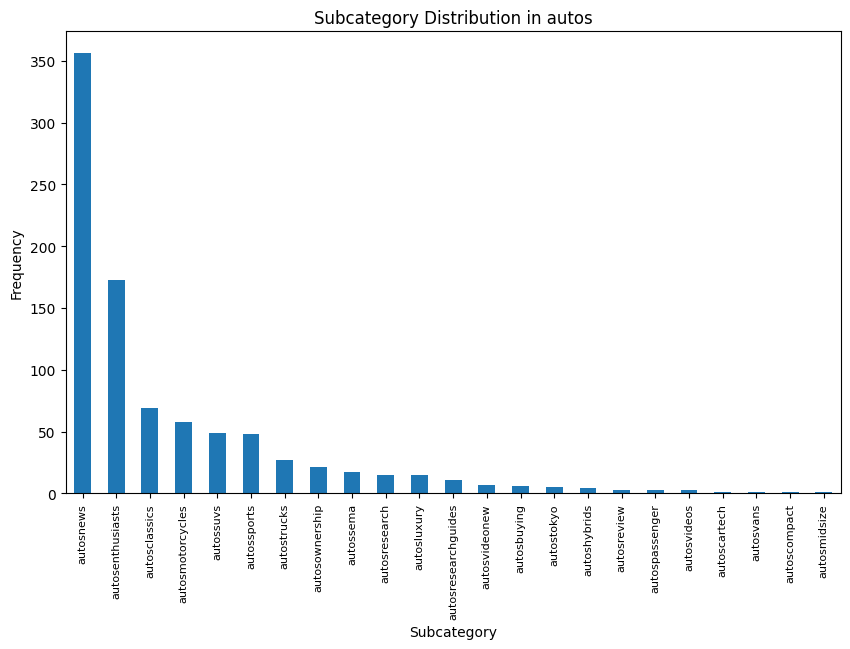

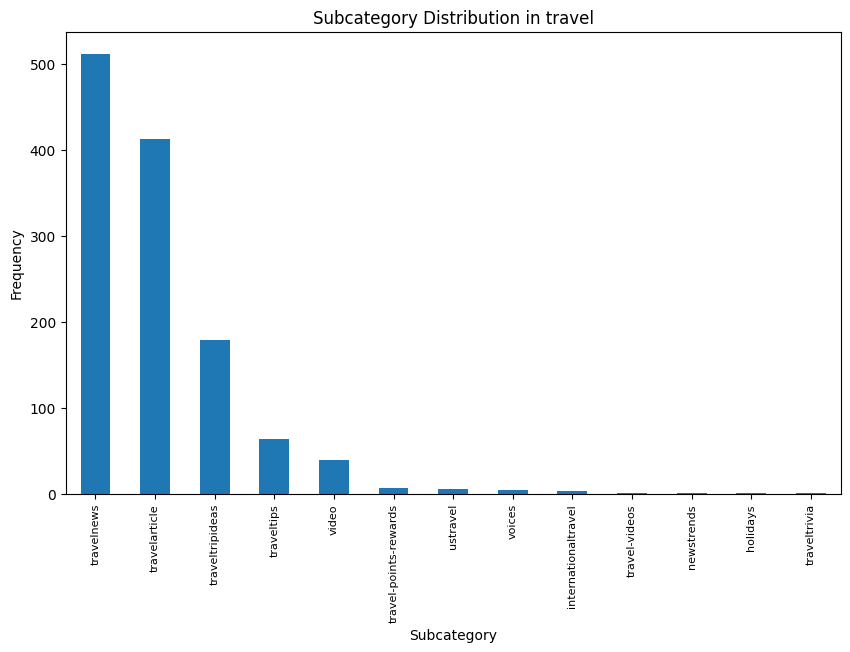

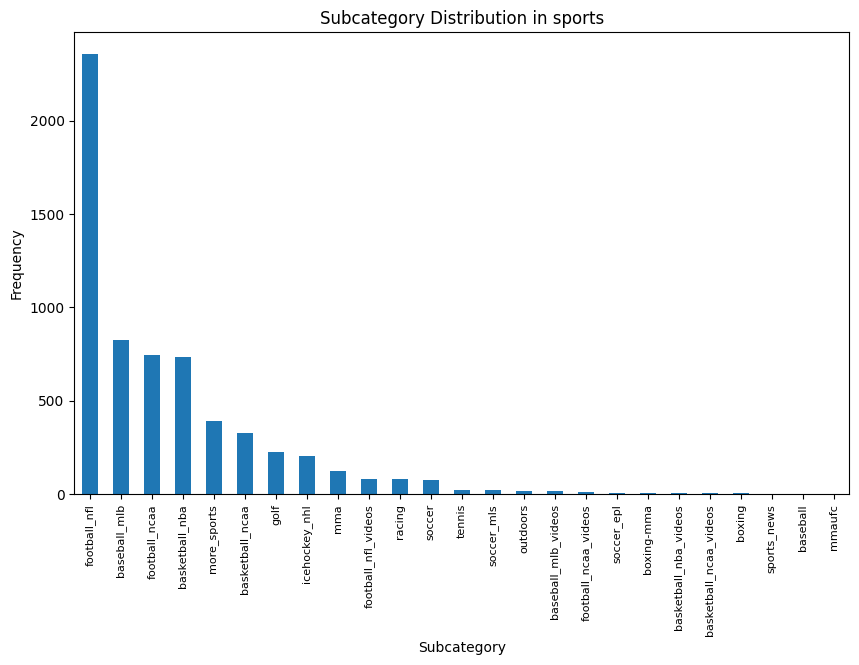

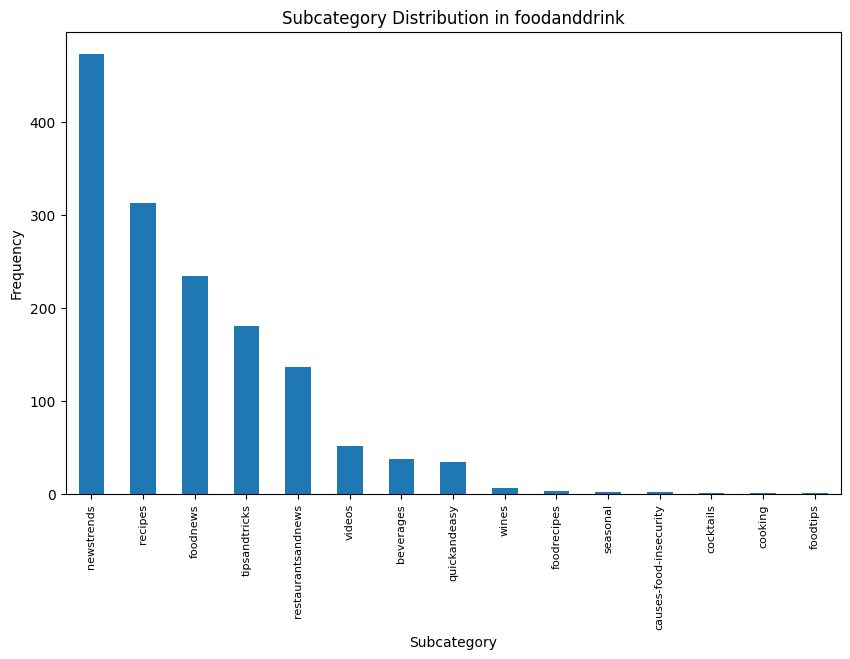

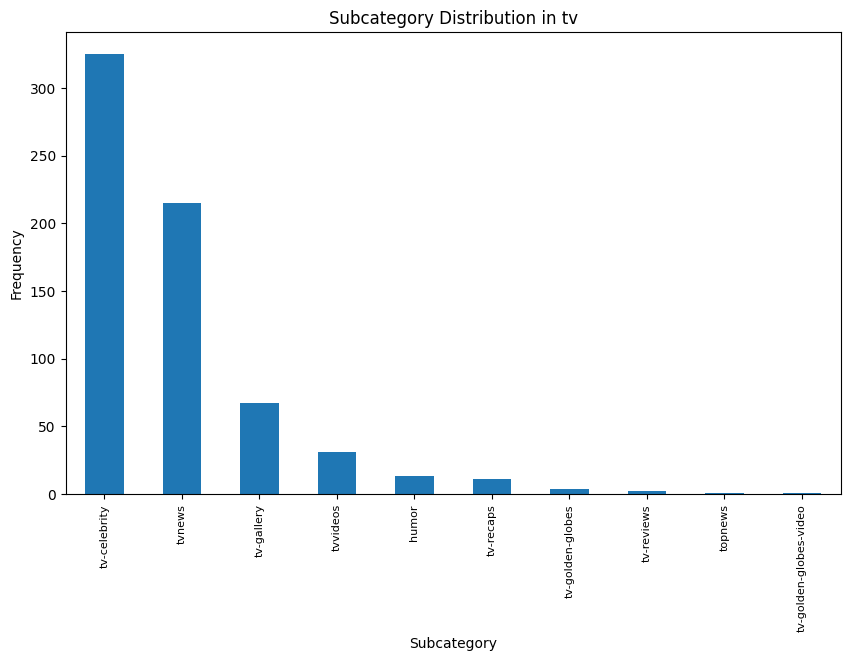

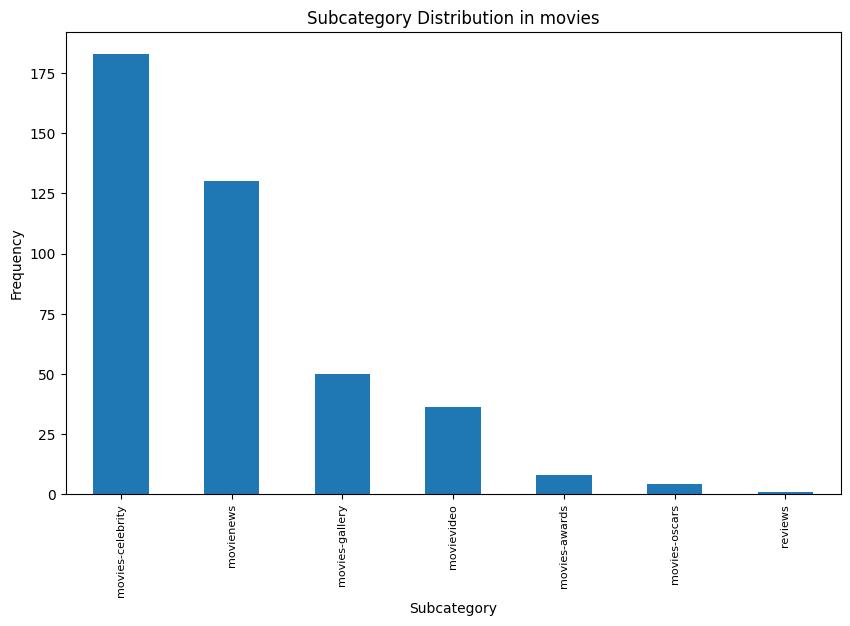

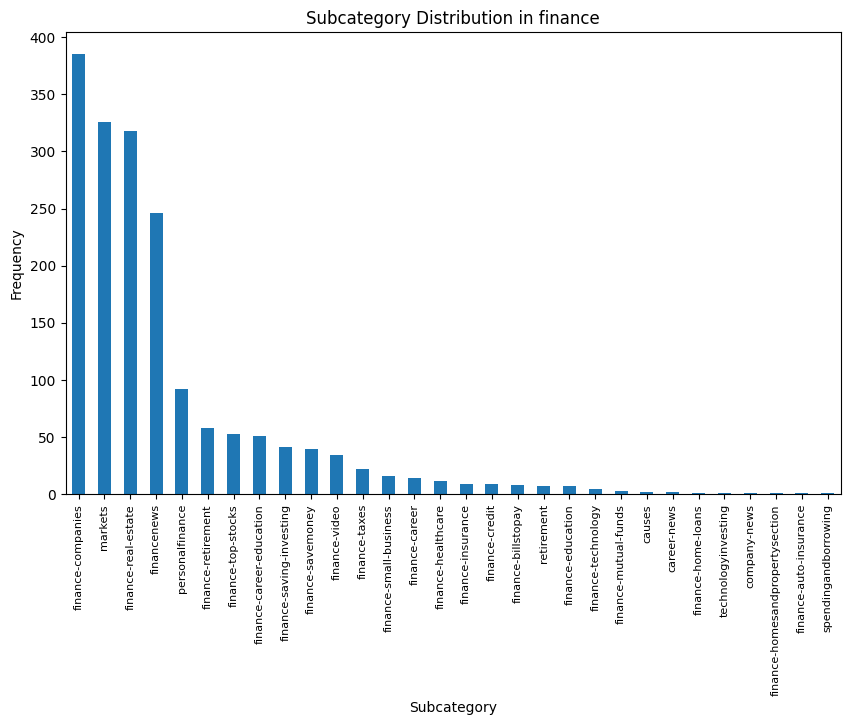

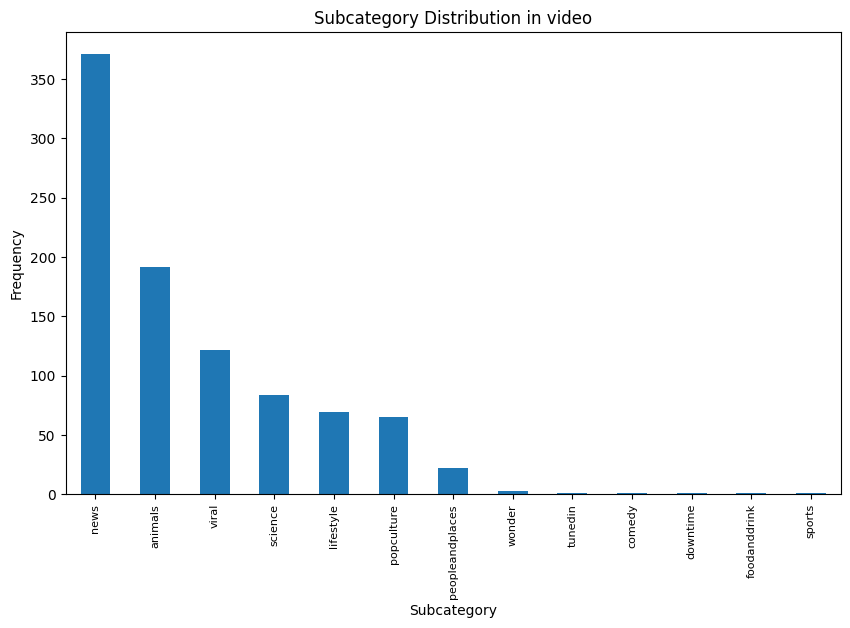

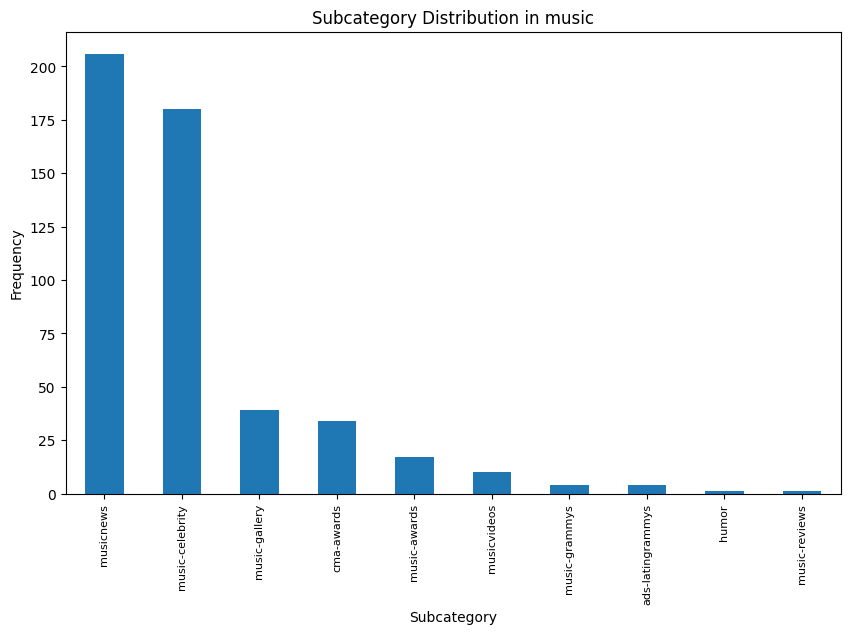

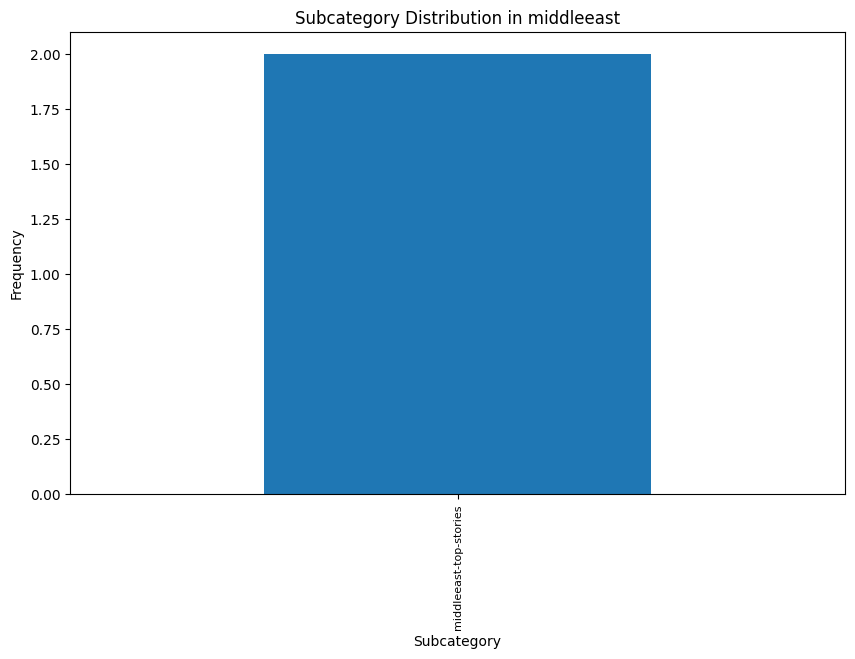

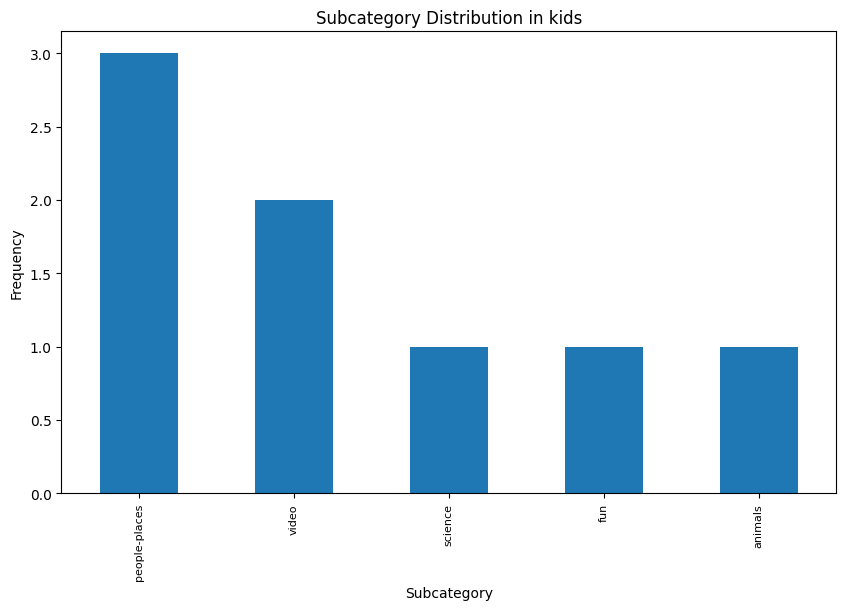

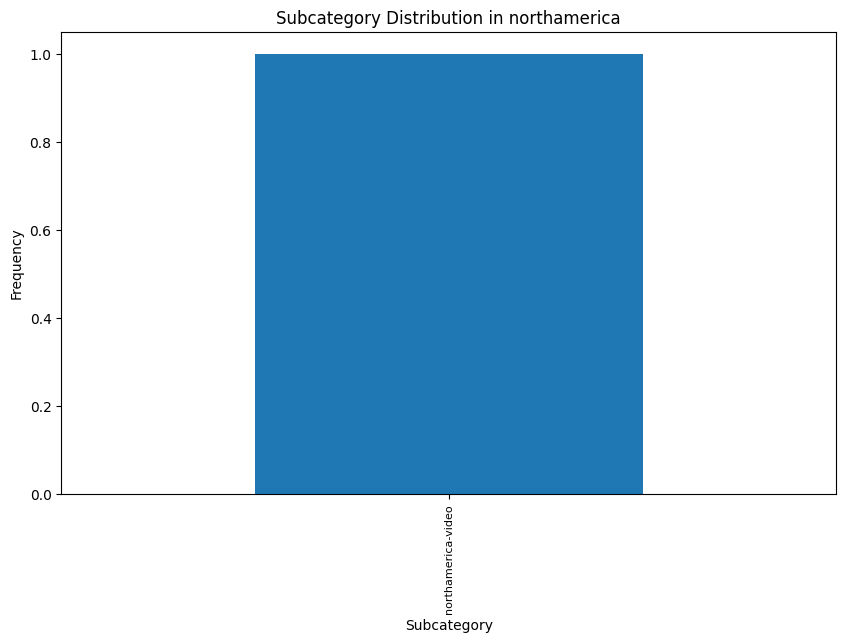

In [9]:
# Get unique categories
categories = df['category'].unique()

# Create a plot for each category
for category in categories:
    # Filter data for the current category
    category_data = df[df['category'] == category]
    
    # Count the occurrences of each subcategory within this category
    subcategory_counts = category_data['subcategory'].value_counts()

    # Plotting
    plt.figure(figsize=(10, 6))
    subcategory_counts.plot(kind='bar')
    plt.title(f'Subcategory Distribution in {category}')
    plt.xlabel('Subcategory')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90, fontsize=8)
    plt.show()

## Reference
\[1\] Chuhan Wu, Fangzhao Wu, Mingxiao An, Jianqiang Huang, Yongfeng Huang and Xing Xie: NPA: Neural News Recommendation with Personalized Attention, KDD 2019, ADS track.<br>
\[2\] Wu, Fangzhao, et al. "MIND: A Large-scale Dataset for News Recommendation" Proceedings of the 58th Annual Meeting of the Association for Computational Linguistics. https://msnews.github.io/competition.html <br>
\[3\] GloVe: Global Vectors for Word Representation. https://nlp.stanford.edu/projects/glove/